# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

In [1]:
import os
os.chdir("..")

Then we import the necessary CerberusTS modules. 

In [2]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator
from cerberus_ts import Foresight, train_foresight

import pandas as pd

c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we have the ability to do some custom configuration:

In [3]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [4]:
df = pd.read_csv(r"data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'], 
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [5]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)   
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use. 

In [6]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 100)

# Prepare the data
preparer.prepare_data()

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [7]:
foresight = Foresight(sizes,feature_indexes)

In [8]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 30)

Epoch [1/30], Loss: 0.024453901757175725
Epoch [2/30], Loss: 0.00938992458085219
Epoch [3/30], Loss: 0.00778445938291649
Epoch [4/30], Loss: 0.00658852988233169
Epoch [5/30], Loss: 0.00564568979665637
Epoch [6/30], Loss: 0.004679621397517621
Epoch [7/30], Loss: 0.0036945516414319474
Epoch [8/30], Loss: 0.002744771452465405
Epoch [9/30], Loss: 0.0019334783847443759
Epoch [10/30], Loss: 0.0011860425343426565
Epoch [11/30], Loss: 0.0007054310891544446
Epoch [12/30], Loss: 0.00043104307105143864
Epoch [13/30], Loss: 0.0002354530568603271
Epoch [14/30], Loss: 0.0001498265807943729
Epoch [15/30], Loss: 9.902813132309044e-05
Epoch [16/30], Loss: 7.457070511009078e-05
Epoch [17/30], Loss: 0.0001729772871476598
Epoch [18/30], Loss: 0.0006124104103461529
Epoch [19/30], Loss: 0.00021535564990093312
Epoch [20/30], Loss: 5.044515011832118e-05
Epoch [21/30], Loss: 2.6159673392006274e-05
Epoch [22/30], Loss: 2.7446608619356994e-05
Epoch [23/30], Loss: 3.261428100813646e-05
Epoch [24/30], Loss: 5.4560

## CerberusTS Training

With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions. 

In [9]:
model = Cerberus(sizes, feature_indexes, foresight=foresight)

In [10]:
model = train_cerberus(model, preparer.dataloaders, num_epochs = 60)

Epoch [1/60], Loss: 0.001294874306768179
Epoch [2/60], Loss: 0.0009279165795305743
Epoch [3/60], Loss: 0.000848988959332928
Epoch [4/60], Loss: 0.00080974976629174
Epoch [5/60], Loss: 0.000801208156044595
Epoch [6/60], Loss: 0.0007582029069696242
Epoch [7/60], Loss: 0.0007367197565811996
Epoch [8/60], Loss: 0.0007112923049135134
Epoch [9/60], Loss: 0.0006714813473323981
Epoch [10/60], Loss: 0.000644483568224435
Epoch [11/60], Loss: 0.0006208343557470168
Epoch [12/60], Loss: 0.0005941941814186672
Epoch [13/60], Loss: 0.0005689638558154305
Epoch [14/60], Loss: 0.0005148807730680952
Epoch [15/60], Loss: 0.0004804994779988192
Epoch [16/60], Loss: 0.00044500474003143607
Epoch [17/60], Loss: 0.00041801172085494424
Epoch [18/60], Loss: 0.00037284545765335983
Epoch [19/60], Loss: 0.0003421928373669895
Epoch [20/60], Loss: 0.00031374930394425366
Epoch [21/60], Loss: 0.000291170699444289
Epoch [22/60], Loss: 0.00026832589113231126
Epoch [23/60], Loss: 0.00024025009401763478
Epoch [24/60], Loss: 

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results. 

### Normalized Response Review

          0         1         2
0  0.864387  0.360522  0.647692
1  0.865940  0.353576  0.659463
2  0.866183  0.347839  0.668848
3  0.865787  0.343233  0.677422
4  0.865715  0.339532  0.685247
5  0.867295  0.336452  0.690616
6  0.867337  0.331414  0.697579
7  0.867072  0.325453  0.706725
8  0.866950  0.321412  0.715265


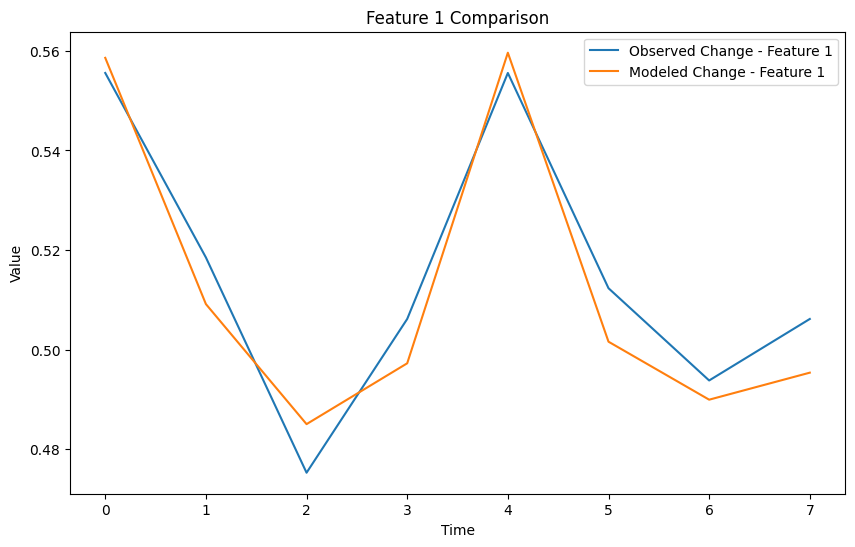

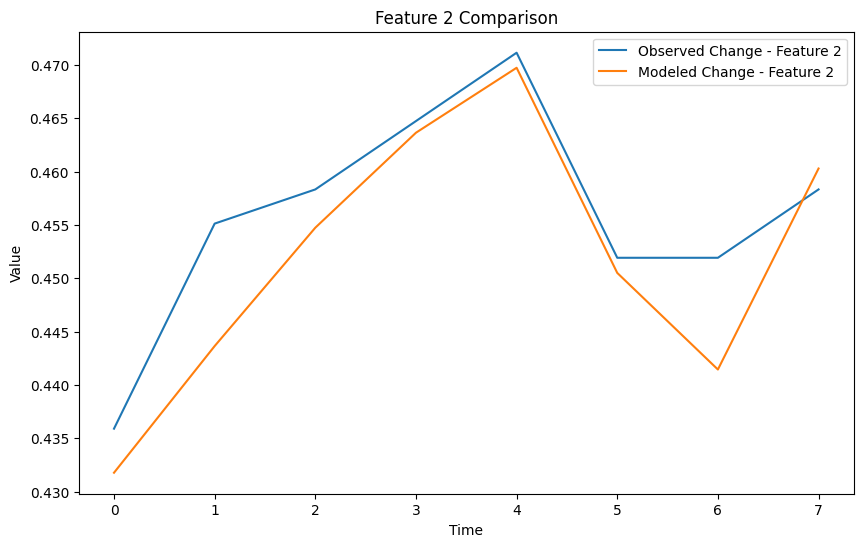

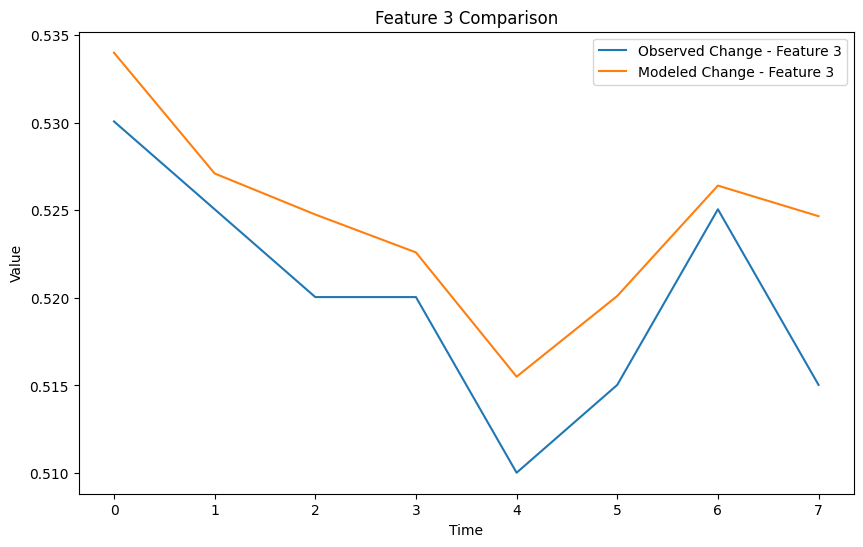

In [71]:
# Intialize Response Generator
generator = ResponseGenerator(model, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 500
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

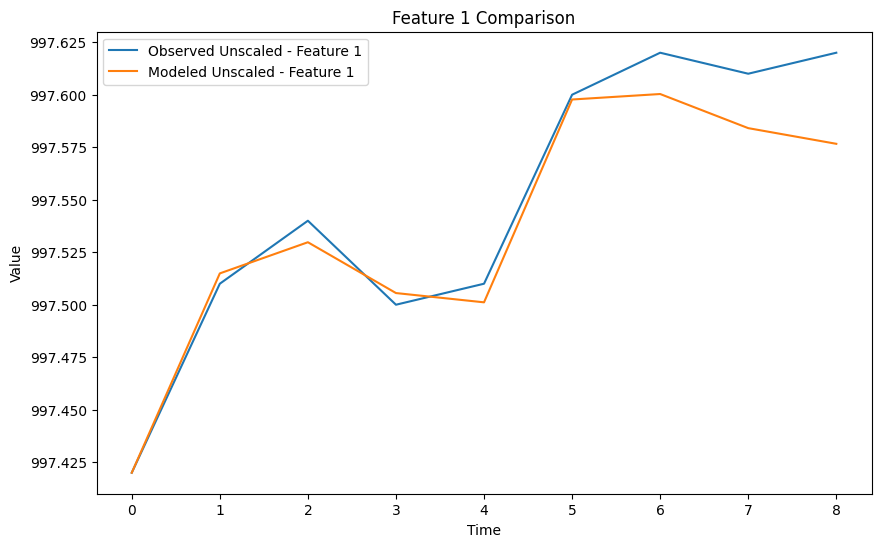

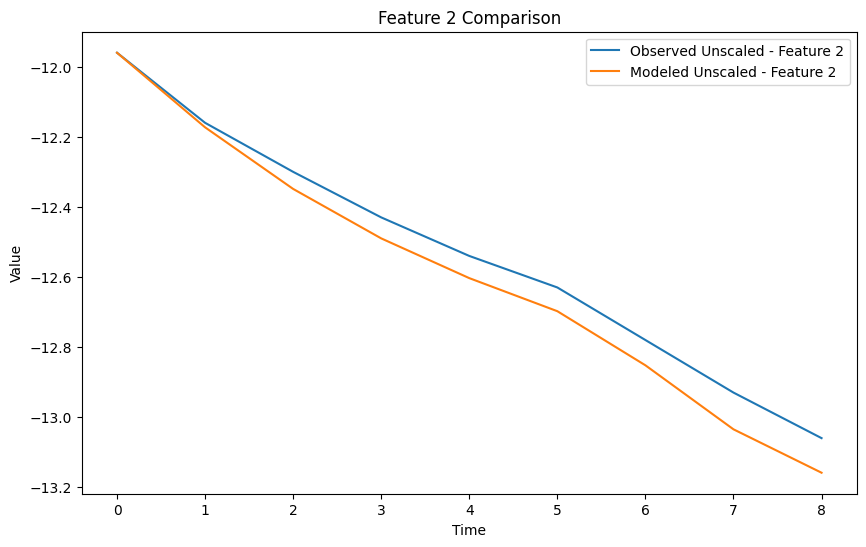

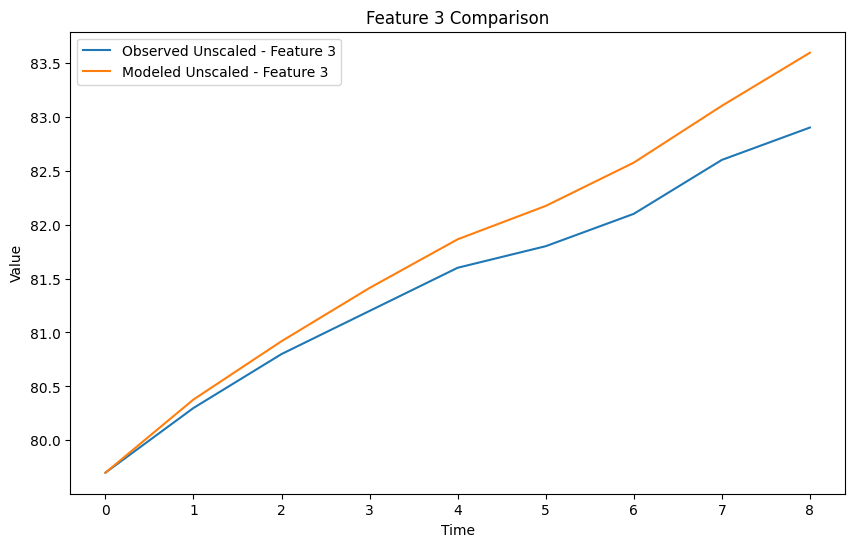

In [73]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)